In [35]:
import pandas as pd
from collections import Counter
import ast

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 

import xgboost as xgb

import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv("nndb.csv")

In [37]:
df["IS_DECEASED"] = df["DIED"].notnull()

In [38]:
df.head()

,ID,LINK,NAME,AKA,BORN,BIRTHPLACE,GENDER,RACE,OCCUPATION,NATIONALITY,...,DIED,LOCATION_OF_DEATH,CAUSE_OF_DEATH,AGE,RISK_FACTORS,WIKI_CAUSE_OF_DEATH,WIKI_DEATH_SUMMARY,WIKI_HEALTH_ISSUES,WIKI_CATEGORIZED_CAUSE,IS_DECEASED
0,e66912fa8bf67ef6c7fa974ac93bac72,http://www.nndb.com/people/148/000163656/,Lyn Z,Lindsey Ann Ballato,1976-05-22,"Dunoon, Scotland",Female,White,NaN,United States,...,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,False
1,3d4a232524cde73e7b1725cdc663bb4b,http://www.nndb.com/people/013/000114668/,Morton Dauwen Zabel,NaN,1901-08-10,NaN,Male,White,NaN,United States,...,1964-04-28,,unspecified,63.0,NaN,unknown,"Morton Dauwen Zabel, who never married, passed...",NaN,other,True
2,fe332275caf5b3ecb55c1a5cd82a959a,http://www.nndb.com/people/076/000131680/,William Zabka,NaN,1965-10-20,NaN,Male,White,Actor,United States,...,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,False
3,a57ebea4e9bd96ea6ef1fa644ad627bb,http://www.nndb.com/people/146/000043017/,Grace Zabriskie,NaN,1941-05-17,NaN,Female,White,Actor,United States,...,NaN,NaN,NaN,83.0,"[\n ""Smoking""\n]",NaN,NaN,NaN,NaN,False
4,0ed81342099b7e06040a4ebb8c01ac77,http://www.nndb.com/people/023/000132624/,Mark Zachares,Mark Dennis Zachares,1958-01-01,NaN,Male,NaN,Government,United States,...,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,False


In [39]:
data = df.RISK_FACTORS.to_list()

In [40]:
# Function to parse and clean individual strings
def parse_and_clean(s):
    # Check for NaN (float) values
    if isinstance(s, float):
        return []
    # Safely evaluate the string as a list
    parsed_list = ast.literal_eval(s)
    # Clean each element in the list
    return [item.strip() for item in parsed_list]

In [41]:
cleaned_data = [parse_and_clean(row) for row in data]

In [42]:
# Normalize the data: strip spaces and convert to lowercase
normalized_data = [[factor.strip().lower() for factor in sublist] for sublist in cleaned_data]

In [43]:
df2 = pd.DataFrame({'RISK_FACTORS': normalized_data})

In [44]:
# Flatten the list and get unique risk factors, normalized
unique_risk_factors = set(factor for sublist in normalized_data for factor in sublist)

In [45]:
# Create DataFrames for each risk factor and store them in a list
encoded_frames = []
for risk_factor in unique_risk_factors:
    # Create a column for each risk factor with 0s
    risk_factor_col = pd.Series([0] * len(df2))
    
    # Update the column with 1 where the risk factor is present
    for i, row in enumerate(df2['RISK_FACTORS']):
        if isinstance(row, list) and risk_factor in [item.lower().strip() for item in row]:
            risk_factor_col.at[i] = 1

    # Add the column to the list of DataFrames
    temp_df = pd.DataFrame({risk_factor: risk_factor_col})
    encoded_frames.append(temp_df)

In [46]:
# Concatenate all the encoded DataFrames
encoded_df = pd.concat(encoded_frames, axis=1)

# Join the encoded DataFrame with the original DataFrame
df = df.join(encoded_df)

In [47]:
df.obesity.value_counts()

obesity
0    36040
1      383
Name: count, dtype: int64

In [48]:
# Drop the original RISK_FACTORS column if necessary
df.drop('RISK_FACTORS', axis=1, inplace=True)

In [49]:
# df['ID'] = df['ID'].astype("category")
df['GENDER'] = df['GENDER'].astype("category")
df['RACE'] = df['RACE'].astype("category")
df['OCCUPATION'] = df['OCCUPATION'].astype("category")
df['NATIONALITY'] = df['NATIONALITY'].astype("category")
df['BIRTHPLACE'] = df['BIRTHPLACE'].astype("category")
df['WIKI_CATEGORIZED_CAUSE'] = df['WIKI_CATEGORIZED_CAUSE'].astype("category")

In [50]:
# Convert the 'date_column' to datetime, coercing out-of-bounds dates to NaT
df['BORN'] = pd.to_datetime(df['BORN'], errors='coerce')
df['DIED'] = pd.to_datetime(df['DIED'], errors='coerce')

# Filter to keep only the rows where the date is >= 1700-01-01
df = df[df['BORN'] >= pd.Timestamp('1700-01-01')]

In [51]:
df_y = df['IS_DECEASED']
df_X = df.drop(columns=['ID', 'IS_DECEASED', 'DIED', 'LOCATION_OF_DEATH', 'CAUSE_OF_DEATH', 'NAME', 'AKA', 'LINK', 'BORN', 'EXECUTIVE_SUMMARY', 'WIKI_CAUSE_OF_DEATH', 'WIKI_DEATH_SUMMARY', 'WIKI_HEALTH_ISSUES'])

In [52]:
id_column = df['ID']
name_column = df['NAME']
age_column = df['AGE']
is_dead_column = df['IS_DECEASED']

In [53]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [54]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.237


In [55]:
def create_pipe(clf):

    pipeline = Pipeline([('clf', clf)])

    return pipeline

In [56]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        tree_method="hist",
                        enable_categorical=True)

pipeline = create_pipe(clf)

In [57]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [58]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(15)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
6,WIKI_CATEGORIZED_CAUSE,0.756222,0.756222
84,performance-enhancing drugs,0.021287,0.777510
128,former smoker,0.015086,0.792595
120,ophidiophobia,0.014924,0.807519
111,bipolar disorder,0.012416,0.819935
107,breast cancer,0.012274,0.832209
28,marijuana,0.011981,0.844190
133,psoriasis,0.010293,0.854483
3,OCCUPATION,0.009551,0.864034
42,bulimia,0.008837,0.872870


In [59]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

       False      0.997     0.984     0.990      5616
        True      0.981     0.996     0.989      4734

    accuracy                          0.990     10350
   macro avg      0.989     0.990     0.990     10350
weighted avg      0.990     0.990     0.990     10350



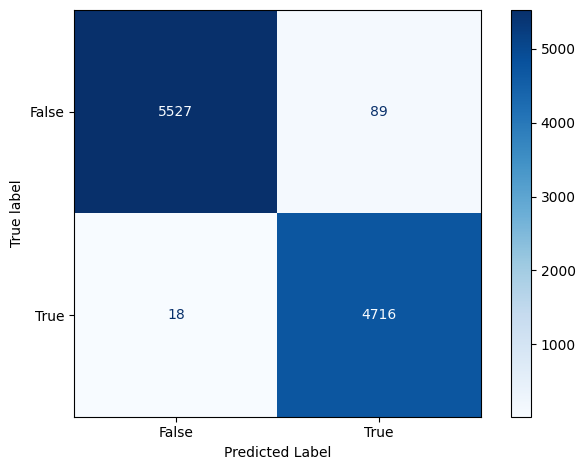

In [60]:
print_confusion(pipeline)

In [61]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
6,WIKI_CATEGORIZED_CAUSE,0.756222,0.756222
84,performance-enhancing drugs,0.021287,0.777510
128,former smoker,0.015086,0.792595
120,ophidiophobia,0.014924,0.807519
111,bipolar disorder,0.012416,0.819935
107,breast cancer,0.012274,0.832209
28,marijuana,0.011981,0.844190
133,psoriasis,0.010293,0.854483
3,OCCUPATION,0.009551,0.864034
42,bulimia,0.008837,0.872870


In [62]:

# Predict the outcome variable based on the model
probs = pipeline.predict_proba(df_X)

# Get the Win probability for the `win` class
probs = probs[:,1]
probs = probs.round(3)

# Combine predictions with the name column
result_df = pd.DataFrame({
    'ID': id_column,
    'NAME': name_column,
    'AGE': age_column,
    'IS_DECEASED': is_dead_column,
    'PREDICTION': probs,
})

# Add the probability percentage to the DataFrame
# X['last_prediction_date'] = pd.Timestamp.today().strftime('%Y-%m-%d')
# X['convert_probability'] = probs.tolist()

In [63]:
result_df = result_df.sort_values('PREDICTION', ascending=False)
result_df

,ID,NAME,AGE,IS_DECEASED,PREDICTION
7001,d36db69985c9f244f5a9b2fa36b6d27f,Conrad Schnitzler,74.0,True,1.0
6969,7f04796c8e43398df2c94c8f8109acf3,Victor de Sabata,75.0,True,1.0
11072,7cbc83e55bbd29e1f4e3bf0e23123403,Michael Shaara,59.0,True,1.0
34795,61e8778e296dca763c5f00f15674b95a,Malcolm Lowry,48.0,True,1.0
11069,741e9b2540771f89f07c9dd732280eb1,Ferry Porsche,89.0,True,1.0
...,...,...,...,...,...
15473,04bc7784927ac0c8ab980e39a42e51c0,Joseph Marcell,76.0,False,0.0
15472,22dd1984534de7eccee6c4b7b4efc978,Barry Manilow,81.0,False,0.0
15471,84cbbdf73aa7bb9d72c717b8fd337c7b,Karen O,46.0,False,0.0
15470,d435d1bc87b8ef9899595a6d2d078a6e,Tony Mauro,75.0,False,0.0


In [64]:
filtered_df = result_df[result_df['IS_DECEASED'] == False]
filtered_df

,ID,NAME,AGE,IS_DECEASED,PREDICTION
6351,8e9dd2fa264a727800772309ebe83a94,S. Jay Stewart,86.0,False,0.999
29483,e1cd0e2d93e2945df00413511d7618a9,Carl XVI Gustaf,78.0,False,0.999
17808,d12a90385ea1ed6552641e7182b3ec0a,Gene Hackman,94.0,False,0.999
36091,7c982f32d03eef4b39cc22e8e03a0f80,Glynis Johns,101.0,False,0.999
33596,d59a365aa8e7f2f5d2375288b6c86993,Jerry Kramer,88.0,False,0.999
...,...,...,...,...,...
15473,04bc7784927ac0c8ab980e39a42e51c0,Joseph Marcell,76.0,False,0.000
15472,22dd1984534de7eccee6c4b7b4efc978,Barry Manilow,81.0,False,0.000
15471,84cbbdf73aa7bb9d72c717b8fd337c7b,Karen O,46.0,False,0.000
15470,d435d1bc87b8ef9899595a6d2d078a6e,Tony Mauro,75.0,False,0.000


In [65]:
df_leads = filtered_df[filtered_df['PREDICTION'] >= 0.75]
df_leads

,ID,NAME,AGE,IS_DECEASED,PREDICTION
6351,8e9dd2fa264a727800772309ebe83a94,S. Jay Stewart,86.0,False,0.999
29483,e1cd0e2d93e2945df00413511d7618a9,Carl XVI Gustaf,78.0,False,0.999
17808,d12a90385ea1ed6552641e7182b3ec0a,Gene Hackman,94.0,False,0.999
36091,7c982f32d03eef4b39cc22e8e03a0f80,Glynis Johns,101.0,False,0.999
33596,d59a365aa8e7f2f5d2375288b6c86993,Jerry Kramer,88.0,False,0.999
...,...,...,...,...,...
809,47c0a6f3b1e487892755853d79315a19,Barbara Walters,95.0,False,0.757
665,cae1b6bd57e7451fb1c067a28c4c0714,T. K. Wetherell,79.0,False,0.755
4904,bc4685a3bcb2399b37d1d835b733d6aa,Suzanne Somers,78.0,False,0.754
27291,4ff9b4785d1427d8c008e7ea2bd2fba7,Terry Bradshaw,76.0,False,0.752


In [66]:
df_leads.to_csv('dead_pool_leads.csv', index=False)
